In [ ]:
# Change in the text data with time even with the country-year fixed effects is noteworthy.
# I checked that the increasing emphasis on international rule of law is the driving force behind this change.
# This change was detected by getting the first latent factor which positively correlates with time.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import plotly.express as px

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("predictions/q8_predictions_filtered.csv")

q8_labels = ['Q8_1', 'Q8_2']
df_q8 = df[df['predicted_combined_label'].isin(q8_labels)].copy()

# --------------------------
# Compute embeddings for each sentence
# --------------------------
model = SentenceTransformer('all-mpnet-base-v2')
sentences = df_q8['sentence'].tolist()
print("Computing embeddings for sentences...")
embeddings = model.encode(sentences, show_progress_bar=True)
df_q8['embedding'] = list(embeddings)

# --------------------------
# Aggregate embeddings per country-year by mean
# --------------------------
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)

agg_emb = (
    df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding']
    .apply(mean_embedding)
    .reset_index()
)

# --------------------------
# Aggregate sentence counts and proportions
# --------------------------
agg_counts = (
    df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label'])
    .size()
    .reset_index(name='sentence_count')
)
total_counts = (
    agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count']
    .sum()
    .reset_index(name='total_q8_count')
)
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q8_count']

agg_q8_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q8_1'].copy()

# Ensure year type matches for merging
agg_q8_1['A_YEAR'] = agg_q8_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)

# Merge embeddings with proportions
agg_merged = agg_q8_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# --------------------------
# Extract latent factors using PCA
# --------------------------
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=10)
latent_factors = pca.fit_transform(X)

for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]

# Convert year to numeric for correlation
agg_merged['A_YEAR_num'] = agg_merged['A_YEAR'].astype(int)

# --------------------------
# Correlation between latent factors and year
# --------------------------
for i in range(1, 11):
    corr = agg_merged[f'latent_factor_{i}'].corr(agg_merged['A_YEAR_num'])
    print(f'Correlation of latent_factor_{i} with year: {corr:.3f}')


Computing embeddings for sentences...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Correlation of latent_factor_1 with year: -0.134
Correlation of latent_factor_2 with year: -0.117
Correlation of latent_factor_3 with year: 0.079
Correlation of latent_factor_4 with year: -0.130
Correlation of latent_factor_5 with year: -0.042
Correlation of latent_factor_6 with year: 0.246
Correlation of latent_factor_7 with year: 0.022
Correlation of latent_factor_8 with year: -0.035
Correlation of latent_factor_9 with year: 0.291
Correlation of latent_factor_10 with year: -0.085


Computing embeddings for sentences...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Correlation between residual latent_factor_6 and mean semantic shift: -0.197
Correlation between residual latent_factor_9 and mean semantic shift: 0.092


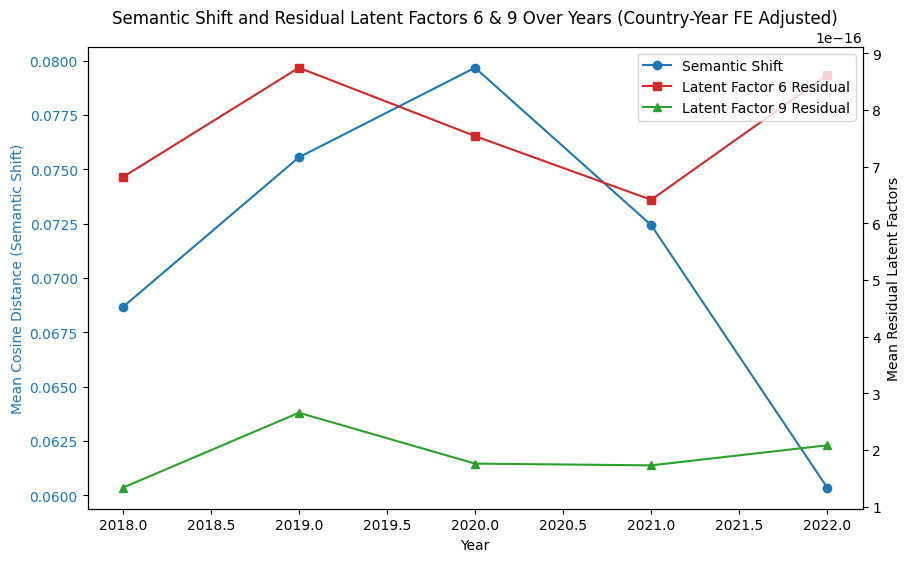

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("predictions/q8_predictions_filtered.csv")

q8_labels = ['Q8_1', 'Q8_2']
df_q8 = df[df['predicted_combined_label'].isin(q8_labels)].copy()

# Step 2: Compute sentence embeddings
model = SentenceTransformer('all-mpnet-base-v2')
sentences = df_q8['sentence'].tolist()
print("Computing embeddings for sentences...")
embeddings = model.encode(sentences, show_progress_bar=True)
df_q8['embedding'] = list(embeddings)

# Step 3: Aggregate embeddings per country-year
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)

agg_emb = (
    df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding']
    .apply(mean_embedding)
    .reset_index()
)

# Step 4: Aggregate sentence counts and proportions
agg_counts = (
    df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label'])
    .size()
    .reset_index(name='sentence_count')
)
total_counts = (
    agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count']
    .sum()
    .reset_index(name='total_q8_count')
)
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q8_count']

agg_q8_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q8_1'].copy()

# Step 5: Fix dtypes for merging
agg_q8_1['A_YEAR'] = agg_q8_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)

# Step 6: Merge embeddings with proportions
agg_merged = agg_q8_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# Add numeric year column for grouping
agg_merged['A_YEAR_int'] = agg_merged['A_YEAR'].astype(int)

# Step 7: Extract latent factors (keep at least 9)
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=10)
latent_factors = pca.fit_transform(X)
for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]

# Step 8: Regress latent_factor_6 and latent_factor_9 on country/year FE
model_fe6 = smf.ols('latent_factor_6 ~ C(B_COUNTRY_ALPHA) + C(A_YEAR)', data=agg_merged).fit()
agg_merged['latent_factor_6_resid'] = model_fe6.resid

model_fe9 = smf.ols('latent_factor_9 ~ C(B_COUNTRY_ALPHA) + C(A_YEAR)', data=agg_merged).fit()
agg_merged['latent_factor_9_resid'] = model_fe9.resid

# Step 9: Compute mean embeddings per year (all countries)
agg_emb['A_YEAR_int'] = agg_emb['A_YEAR'].astype(int)
mean_emb_by_year = agg_emb.groupby('A_YEAR_int')['embedding'].apply(lambda embs: np.mean(np.vstack(embs), axis=0))
mean_emb_by_year = mean_emb_by_year.sort_index()

# Step 10: Compute cosine distances between consecutive years
years = mean_emb_by_year.index.to_list()
distances = []
for i in range(1, len(years)):
    d = cosine_distances(
        mean_emb_by_year.iloc[i-1].reshape(1, -1),
        mean_emb_by_year.iloc[i].reshape(1, -1)
    )[0][0]
    distances.append(d)

semantic_shift_df = pd.DataFrame({
    'A_YEAR_int': years[1:],
    'mean_cosine_distance': distances
})

# Step 11: Calculate mean residuals for factors 6 and 9 per year
latent_year_avg6 = agg_merged.groupby('A_YEAR_int')['latent_factor_6_resid'].mean().reset_index()
latent_year_avg9 = agg_merged.groupby('A_YEAR_int')['latent_factor_9_resid'].mean().reset_index()

# Step 12: Merge everything into one DataFrame
analysis_df = semantic_shift_df.merge(latent_year_avg6, on='A_YEAR_int')
analysis_df = analysis_df.merge(latent_year_avg9, on='A_YEAR_int')

# Step 13: Correlate each factor with semantic shift
corr6 = analysis_df['latent_factor_6_resid'].corr(analysis_df['mean_cosine_distance'])
corr9 = analysis_df['latent_factor_9_resid'].corr(analysis_df['mean_cosine_distance'])
print(f"Correlation between residual latent_factor_6 and mean semantic shift: {corr6:.3f}")
print(f"Correlation between residual latent_factor_9 and mean semantic shift: {corr9:.3f}")

# Step 14: Plot results — all three lines on one plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Cosine Distance (Semantic Shift)', color=color1)
ax1.plot(analysis_df['A_YEAR_int'], analysis_df['mean_cosine_distance'], marker='o', color=color1, label='Semantic Shift')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
color3 = 'tab:green'
ax2.set_ylabel('Mean Residual Latent Factors', color='black')
ax2.plot(analysis_df['A_YEAR_int'], analysis_df['latent_factor_6_resid'], marker='s', color=color2, label='Latent Factor 6 Residual')
ax2.plot(analysis_df['A_YEAR_int'], analysis_df['latent_factor_9_resid'], marker='^', color=color3, label='Latent Factor 9 Residual')
ax2.tick_params(axis='y', labelcolor='black')

fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title('Semantic Shift and Residual Latent Factors 6 & 9 Over Years (Country-Year FE Adjusted)')
plt.show()


Computing sentence embeddings...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Themes for high latent_factor_6 sentences:
- self realization youth create (0.582)
- realization youth create (0.577)
- young people education (0.575)
- young people future (0.566)
- development young people (0.564)
- submission adolescence humankind (0.562)
- young people education form (0.558)
- freedom today self determination (0.556)
- freedom dignity self determination (0.553)
- conditions self realization youth (0.553)


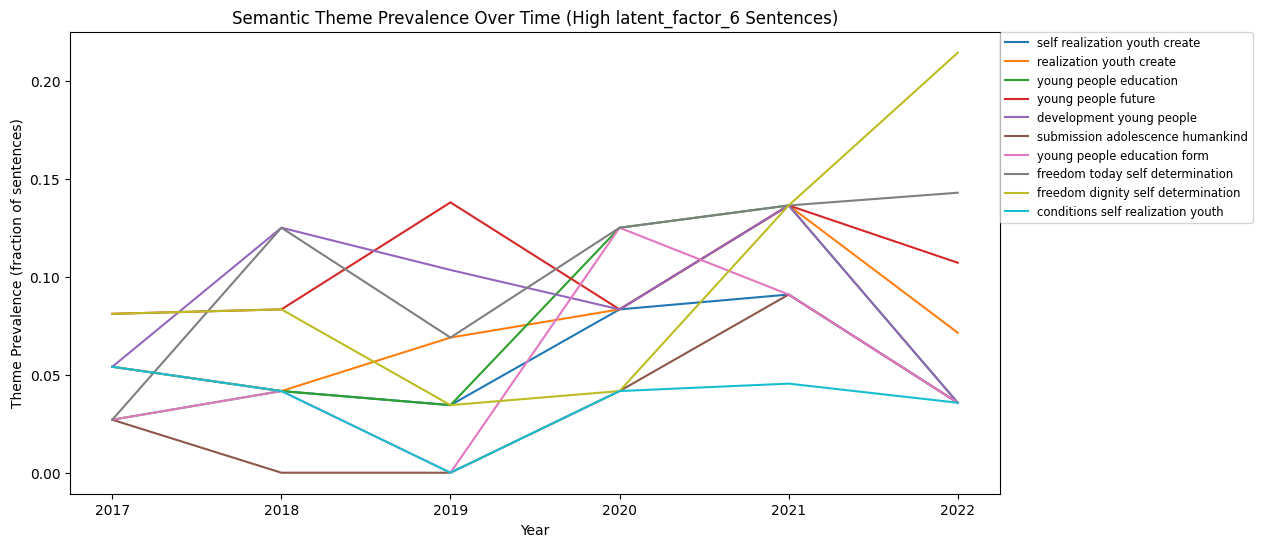


Themes for high latent_factor_9 sentences:
- opportunities women youth protection (0.596)
- education responsibility society responsibility (0.594)
- responsibility protecting women girls (0.593)
- education children (0.576)
- education responsibility (0.565)
- education children young people (0.559)
- share responsibility protecting women (0.554)
- empowerment uniquely gender emancipation (0.552)
- responsibility protecting women (0.550)
- education responsibility society (0.544)


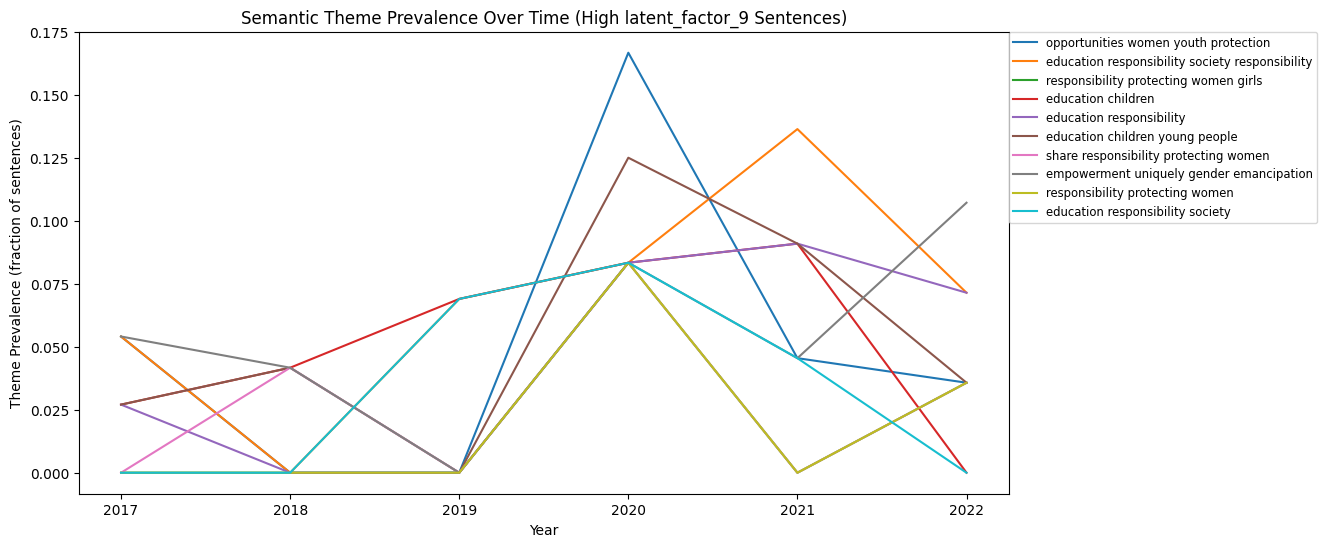

In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

# -------------------
# Load data and filter
# -------------------
df = pd.read_csv("predictions/q8_predictions_filtered.csv")
q8_labels = ['Q8_1', 'Q8_2']
df_q8 = df[df['predicted_combined_label'].isin(q8_labels)].copy()

# -------------------
# Compute embeddings
# -------------------
model = SentenceTransformer('all-mpnet-base-v2')
print("Computing sentence embeddings...")
df_q8['embedding'] = list(model.encode(df_q8['sentence'].tolist(), show_progress_bar=True))

# -------------------
# Aggregate embeddings per country-year
# -------------------
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)
agg_emb = df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding'].apply(mean_embedding).reset_index()

# -------------------
# Aggregate counts and proportions
# -------------------
agg_counts = df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label']).size().reset_index(name='sentence_count')
total_counts = agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count'].sum().reset_index(name='total_q8_count')
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q8_count']
agg_q8_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q8_1'].copy()
agg_q8_1['A_YEAR'] = agg_q8_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)
agg_merged = agg_q8_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# -------------------
# PCA for latent factors
# -------------------
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=10)  # ensure factors 6 and 9 exist
latent_factors = pca.fit_transform(X)
for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]

# -------------------
# Merge factor values back to original sentences
# -------------------
agg_factor = agg_merged[['B_COUNTRY_ALPHA', 'A_YEAR', 'latent_factor_6', 'latent_factor_9']].copy()
agg_factor['A_YEAR'] = agg_factor['A_YEAR'].astype(str)
df_q8['A_YEAR'] = df_q8['A_YEAR'].astype(str)
df_q8_with_factor = df_q8.merge(agg_factor, on=['B_COUNTRY_ALPHA', 'A_YEAR'], how='left')

# -------------------
# Function for analysis and plotting per factor
# -------------------
def analyze_factor(df, factor_name):
    # Get top 200 sentences by this factor
    top_pos = df.sort_values(factor_name, ascending=False).head(200)

    # Extract themes using KeyBERT
    kw_model = KeyBERT('all-mpnet-base-v2')
    def extract_themes(texts, top_n=10):
        corpus = " ".join(texts)
        return kw_model.extract_keywords(corpus, keyphrase_ngram_range=(1, 4), stop_words='english', top_n=top_n)

    themes_pos = extract_themes(top_pos['sentence'].tolist())
    print(f"\nThemes for high {factor_name} sentences:")
    for theme, score in themes_pos:
        print(f"- {theme} ({score:.3f})")

    # Embed the theme phrases
    theme_texts = [t[0] for t in themes_pos]
    theme_embeddings = model.encode(theme_texts)

    # Compute cosine similarity between every sentence and each theme
    sentence_embeddings = np.vstack(df['embedding'].values)
    similarity_matrix = cosine_similarity(sentence_embeddings, theme_embeddings)

    # Set similarity threshold to count a sentence as expressing that theme
    threshold = 0.5

    # Compute yearly prevalence
    df['A_YEAR_int'] = df['A_YEAR'].astype(int)
    theme_prevalence = {}
    for i, theme in enumerate(theme_texts):
        theme_mask = similarity_matrix[:, i] > threshold
        df[f'theme_{i}_match'] = theme_mask
        prevalence = df.groupby('A_YEAR_int')[f'theme_{i}_match'].mean()
        theme_prevalence[theme] = prevalence

    prevalence_df = pd.DataFrame(theme_prevalence)

    # Plot
    plt.figure(figsize=(12, 6))
    for theme in prevalence_df.columns[:10]:
        plt.plot(prevalence_df.index, prevalence_df[theme], label=theme)

    plt.xlabel('Year')
    plt.ylabel('Theme Prevalence (fraction of sentences)')
    plt.title(f'Semantic Theme Prevalence Over Time (High {factor_name} Sentences)')
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)
    plt.show()

# -------------------
# Run for factor 6 and factor 9
# -------------------
analyze_factor(df_q8_with_factor.copy(), 'latent_factor_6')
analyze_factor(df_q8_with_factor.copy(), 'latent_factor_9')


In [5]:
import pandas as pd
import plotly.express as px
import statsmodels.formula.api as smf

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("predictions/q8_predictions_filtered.csv")

# Select Q8 labels
q8_labels = ['Q8_1', 'Q8_2']
df_q8 = df[df['predicted_combined_label'].isin(q8_labels)]

# -----------------------------
# Aggregate counts per country-year-label
# -----------------------------
agg = df_q8.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label']).size().reset_index(name='sentence_count')

# Total sentences per country-year (all Q8)
total_counts = agg.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count'].sum().reset_index(name='total_q8_count')

agg = agg.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# Compute proportions
agg['proportion'] = agg['sentence_count'] / agg['total_q8_count']

# -----------------------------
# Filter for Q8_1 only
# -----------------------------
agg_q8_1 = agg[agg['predicted_combined_label'] == 'Q8_1'].copy()

# -----------------------------
# Fit OLS with country and year fixed effects
# -----------------------------
model = smf.ols('proportion ~ C(B_COUNTRY_ALPHA) + C(A_YEAR)', data=agg_q8_1).fit()

# Add fitted values and residuals
agg_q8_1['fitted_proportion'] = model.fittedvalues
agg_q8_1['residuals'] = model.resid

# -----------------------------
# Create combined country-year string for x-axis
# -----------------------------
agg_q8_1['COUNTRY_YEAR'] = agg_q8_1['B_COUNTRY_ALPHA'] + ' ' + agg_q8_1['A_YEAR'].astype(str)

agg_q8_1['COUNTRY_YEAR'] = pd.Categorical(
    agg_q8_1['COUNTRY_YEAR'],
    categories=sorted(agg_q8_1['COUNTRY_YEAR'].unique()),
    ordered=True
)

# -----------------------------
# Plot adjusted (fitted) proportions
# -----------------------------
fig = px.scatter(
    agg_q8_1,
    x='COUNTRY_YEAR',
    y='fitted_proportion',
    size='sentence_count',
    color='B_COUNTRY_ALPHA',
    hover_name='COUNTRY_YEAR',
    labels={
        'COUNTRY_YEAR': 'Country Year',
        'fitted_proportion': 'Adjusted Proportion of Q8_1',
        'sentence_count': 'Sentence Count'
    },
    title='Adjusted Proportion of Q8_1 Sentences (Year & Country Fixed Effects)',
    size_max=40,
    height=600
)

fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': sorted(agg_q8_1['COUNTRY_YEAR'].unique())},
    legend_title_text='Country',
    margin=dict(l=40, r=40, t=80, b=40),
    xaxis_tickangle=45
)

fig.show()
